In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
import os
from scipy.stats.mstats import winsorize
from tqdm import tqdm
import seaborn as sns
import sklearn
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier,XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import  train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import ClusterCentroids,RandomUnderSampler
from sklearn import svm
from scipy import interp
from sklearn.ensemble import RandomForestClassifier, IsolationForest, BaggingClassifier, VotingClassifier,ExtraTreesClassifier
from imblearn.ensemble import EasyEnsembleClassifier
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["font.sans-serif"]="Times New Roman"

In [46]:
# 读取数据
train_data=pd.read_csv(r"Dataset/cs-training.csv",index_col="Unnamed: 0")
test_data=pd.read_csv(r"Dataset/cs-test.csv",index_col="Unnamed: 0")
column_names=["Default","Balance_r","Age","Worse_1m", "Debt_r","Income","Credit_num","Worse_3m","Estate_num","Worse_2m","Family_num"]
train_data.columns=column_names
test_data.columns=column_names
train_data=train_data[~(train_data["Balance_r"]>1)]
train_data = train_data[~(train_data["Age"]<20)]
skew =train_data.skew().sort_values(ascending =False )
skew_df= pd.DataFrame({'skew':skew})
skew_index=skew_df[skew_df>10].dropna().index
log_data=np.log(train_data[skew_index]+1)
train_data1=train_data.copy()
train_data1[skew_index]=log_data
for name in column_names:
    train_data1[name]=winsorize(train_data1[name], limits=[0.005,0.005],nan_policy="omit")

# 特征提取


# 预测部分

## 准备工作
### 对test的数据处理
考虑到之前我们对train样本做了一定的处理, 我们必须对test的样本也做相同的处理. 不同于train_data, 对于明显有错误的值, 我们不能直接删除, 而是要将其转化为缺失值.

In [47]:
tmp_balance=test_data["Balance_r"].copy()
tmp_balance[tmp_balance>1]=np.nan
test_data["Balance_r"]=tmp_balance # 将Balance_r超过1的重新设为np.nan
test_data[skew_index]=np.log(test_data[skew_index]+1)
max_value=train_data1.max()
for name, value in max_value[1:].iteritems():
    tmp=test_data[name].copy()
    tmp[tmp>value]=value
    test_data[name]=tmp

In [48]:
y_train=train_data1["Default"]
X_train=train_data1.drop(['Default'], axis=1)
X_test=test_data.drop(['Default'], axis=1)

### 缺失值填充
为了最大限度地使用训练样本, 我们选择填充缺失值而不是将缺失值所在的行直接删去. 当某一个元素缺失时, 我们通过其所在行其他列上的数据来预测缺失值的值. 这里采用了xgboost方法

In [49]:
def fillna_XGB(label):
    xgbr=XGBRegressor()
    nn_data=X_train[~X_train[label].isnull()].copy()
    y_=nn_data[label]
    X_=nn_data.drop(label,axis=1)
    xgbr.fit(X_,y_)
    train_X_missing=X_train[X_train[label].isnull()].drop([label],axis=1)
    test_X_missing=X_test[X_test[label].isnull()].drop([label],axis=1)
    train_y_pred=xgbr.predict(train_X_missing)
    test_y_pred=xgbr.predict(test_X_missing)
    if X_train[label].isnull().any():
        X_train.loc[(X_train[label].isnull()), label]=train_y_pred
    if X_test[label].isnull().any():
        X_test.loc[(X_test[label].isnull()), label]=test_y_pred
fillna_XGB("Income")
fillna_XGB("Family_num")
fillna_XGB("Balance_r")

### 可视化函数

In [50]:
# ROC曲线
def AUC_ROC(X,model):
    # 设置图形大小
    fig = plt.figure(figsize=(14, 10))

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    # 计算 预测率
    probas = model.predict_proba(X)
    # 计算 fpr,tpr
    fpr, tpr, thresholds = roc_curve(y_validation, probas[:, 1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr,  tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.5f)'
                        % ( roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')

    mean_tpr /= len(X_training)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot([0, 0, 1],
             [0, 1, 1],
             lw=2,
             linestyle=':',
             color='black',
             label='perfect performance')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False positive rate', size=15)
    plt.ylabel('True Positive Rate', size=15)
    plt.title('ROC-AUC Plot', size=20)
    plt.legend(loc="lower right")
    plt.show()

# 混淆矩阵
def confusion(X, model):
    y_pred=model.predict(X)
    confmat = confusion_matrix(y_true=y_validation, y_pred=y_pred)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

### 划分训练集和验证集
为了避免过拟合, 我们不直接使用test data, 而是选择将训练集划分为一个训练集和一个验证集, 这里确定一个随机数种子以保证后续分析的相同的数据.

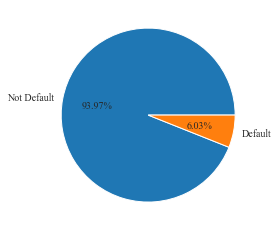

In [8]:
X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state = 2022)
plt.pie([(y_training==0).sum(),(y_training!=0).sum()], labels=["Not Default","Default"], autopct='%.2f%%')
plt.show()

从上面的扇形统计图中可以看出, 正负类的样本极度不均衡, 比例约为14:1. 这意味着我们需要进行一些数据平衡的操作. 然而, 对于不同的样本集, 我们可以有不同的数据平衡方式. 为此, 我们必须选择一个合适的采样方式. 我们下面根据最简单的RandomForest的结果来进行采样方式的选择

### 采样方式

In [ ]:
# 不进行采样的结果基准
seed_pool=[1,20, 123,2022, 3212]
res=[]
for seed in seed_pool:
    X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state = seed)
    model=RandomForestClassifier(n_estimators=200, max_depth=7, min_samples_leaf=16,n_jobs=-1)
    model.fit(X_training,y_training)
    print(y_training.sum()/y_training.count())
    auc_res=roc_auc_score(y_validation, model.predict_proba(X_validation)[:,1])
    res.append(auc_res)
print(res)
np.array(res).mean()

In [53]:

# SMOTE 过采样
res=[]
for seed in seed_pool:
    X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state = seed)
    smo = SMOTE(random_state=seed)
    X_training, y_training = smo.fit_resample(X_training, y_training)
    model=RandomForestClassifier(n_estimators=200, max_depth=7, min_samples_leaf=16,n_jobs=-1)
    model.fit(X_training,y_training)
    auc_res=roc_auc_score(y_validation, model.predict_proba(X_validation)[:,1])
    res.append(auc_res)
print(res)
np.array(res).mean()


[0.8499458640949251, 0.8456513588750776, 0.8375866382181419, 0.8447196240018157, 0.8382859301148411]


0.8432378830609603

In [55]:
# Random 过采样
res=[]
for seed in seed_pool:
    X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state = seed)
    ros=RandomOverSampler(random_state=seed)
    X_training, y_training = ros.fit_resample(X_training, y_training)
    model=RandomForestClassifier(n_estimators=200, max_depth=7, min_samples_leaf=16,n_jobs=-1)
    model.fit(X_training,y_training)
    auc_res=roc_auc_score(y_validation, model.predict_proba(X_validation)[:,1])
    res.append(auc_res)
print(res)
np.array(res).mean()

[0.8555021246673876, 0.8512735055491374, 0.8461515775800761, 0.852996303024627, 0.8444128959595563]


0.850067281356157

In [58]:
#ADASYN过采样

res=[]
for seed in seed_pool:
    X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state = seed)
    ada=ADASYN(random_state=seed)
    X_training, y_training = ada.fit_resample(X_training, y_training)
    model=RandomForestClassifier(n_estimators=200, max_depth=7, min_samples_leaf=16,n_jobs=-1)
    model.fit(X_training,y_training)
    auc_res=roc_auc_score(y_validation, model.predict_proba(X_validation)[:,1])
    res.append(auc_res)
print(res)
np.array(res).mean()

[0.8475164492352949, 0.8444175460239762, 0.8362411988420841, 0.8425888127767588, 0.8372539453577407]


0.841603590447171

In [67]:
# Random 欠采样

res=[]
for seed in seed_pool:
    X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state = seed)
    rus=RandomUnderSampler(random_state=seed)
    X_training, y_training = rus.fit_resample(X_training, y_training)
    model=RandomForestClassifier(n_estimators=200, max_depth=7, min_samples_leaf=16,n_jobs=-1)
    model.fit(X_training,y_training)
    auc_res=roc_auc_score(y_validation, model.predict_proba(X_validation)[:,1])
    res.append(auc_res)
print(res)
np.array(res).mean()

[0.8559820279050876, 0.851354288974555, 0.8460204014064355, 0.8534244500479158, 0.8445984022656591]


0.8502759141199305

In [73]:
#SMOTEENN 组合采样

res=[]
for seed in tqdm(seed_pool):
    X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state = seed)
    se=SMOTEENN(random_state=seed)
    X_training, y_training = se.fit_resample(X_training, y_training)
    model=RandomForestClassifier(n_estimators=200, max_depth=7, min_samples_leaf=16,n_jobs=-1)
    model.fit(X_training,y_training)
    auc_res=roc_auc_score(y_validation, model.predict_proba(X_validation)[:,1])
    res.append(auc_res)
print(res)
np.array(res).mean()

100%|██████████| 5/5 [00:41<00:00,  8.21s/it]

[0.85015224900419, 0.8466627480911705, 0.8378713811237202, 0.8460350749048992, 0.8402363979810994]


0.8441915702210159

In [74]:
# SMOTETomek 组合采样
res=[]
for seed in tqdm(seed_pool):
    X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state = seed)
    se=SMOTETomek(random_state=seed)
    X_training, y_training = se.fit_resample(X_training, y_training)
    model=RandomForestClassifier(n_estimators=200, max_depth=7, min_samples_leaf=16,n_jobs=-1)
    model.fit(X_training,y_training)
    auc_res=roc_auc_score(y_validation, model.predict_proba(X_validation)[:,1])
    res.append(auc_res)
print(res)
np.array(res).mean()

100%|██████████| 5/5 [00:36<00:00,  7.23s/it]

[0.8491735341139358, 0.8456799523536486, 0.8366305365922542, 0.844249035120335, 0.8382049909379103]


0.8427876098236167

综合上面的采样方式, 似乎random的过采样和random的降采样是最好的两个选择, 之前我们用的都是充分平衡数据, 这意味着我们可能忽略了一些数据分布的先验信息, 下面针对random过采样和random欠采样尝试一下不那么平衡的样本

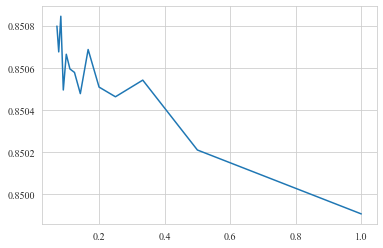

In [91]:
# Random 过采样
result=[]
for rate in tqdm(np.arange(1,15)):
    rate=1/rate
    res=[]
    for seed in seed_pool:
        X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state = seed)
        ros=RandomOverSampler(random_state=seed, sampling_strategy=rate)
        X_training, y_training = ros.fit_resample(X_training, y_training)
        model=RandomForestClassifier(n_estimators=200, max_depth=7, min_samples_leaf=16,n_jobs=-1)
        model.fit(X_training,y_training)
        auc_res=roc_auc_score(y_validation, model.predict_proba(X_validation)[:,1])
        res.append(auc_res)
    result.append(np.array(res).mean())
plt.plot(np.arange(0.2,1,0.1), result)
plt.plot(1/np.arange(1,15), result)

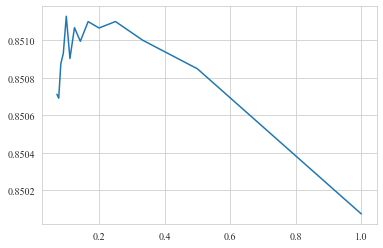

In [93]:
# Random 欠采样

result=[]
for rate in tqdm(np.arange(1,15)):
    rate=1/rate
    res=[]
    for seed in seed_pool:
        X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state = seed)
        rus=RandomUnderSampler(random_state=seed, sampling_strategy=rate)
        X_training, y_training = ros.fit_resample(X_training, y_training)
        model=RandomForestClassifier(n_estimators=200, max_depth=7, min_samples_leaf=16,n_jobs=-1)
        model.fit(X_training,y_training)
        auc_res=roc_auc_score(y_validation, model.predict_proba(X_validation)[:,1])
        res.append(auc_res)
    result.append(np.array(res).mean())

plt.plot(1/np.arange(1,15), result)

遵循上面的两幅图, 我们发现当过采样时, 模型随着过采样数的增加性能不断下降. 而当欠采样时, 有一个比较稳定的平台. 因此我们最终选择欠采样方法, 采样比例为1-0=1:5, 也就是sampling strategy=0.2

最后一个问题是, 集成可以让结果变得更好吗? 我们来看用随机森林进行的easy ensemble的结果, 发现结果有一定的不太明显的提高, 因此这也为我们后面进一步集成提供了想法

In [95]:
# 集成
res=[]
for seed in tqdm(seed_pool):
    X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state = seed)
    model=RandomForestClassifier(n_estimators=200, max_depth=7, min_samples_leaf=16,n_jobs=-1)
    ee=EasyEnsembleClassifier(random_state=0, n_estimators=20,base_estimator=model, sampling_strategy=0.2)
    ee.fit(X_training,y_training)
    auc_res=roc_auc_score(y_validation, ee.predict_proba(X_validation)[:,1])
    res.append(auc_res)
print(res)
np.array(res).mean()

100%|██████████| 5/5 [01:14<00:00, 14.81s/it]

[0.8564236662025875, 0.8526935160721422, 0.8476644871323278, 0.8543106693748524, 0.845136906351117]


0.8512458490266054

In [103]:
# 定义训练集和验证集
X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state = 2022)
rus=RandomUnderSampler(random_state=2022, sampling_strategy=0.2)
X_training, y_training=rus.fit_resample(X_training,y_training)

#定义一个5组数据的集合, 用于调参
seed_list=[1,11,101,1001,2022]
X_train_5, y_train_5, X_test_5,y_test_5=[],[],[],[]
for seed in seed_list:
    X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size = 0.3, random_state = seed)
    rus=RandomUnderSampler(random_state=seed, sampling_strategy=0.2)
    X_training, y_training=rus.fit_resample(X_training,y_training)
    X_train_5.append(X_training)
    y_train_5.append(y_training)
    X_test_5.append(X_validation)
    y_test_5.append(y_validation)

## 线性模型构建
### Logistic 回归
首先先使用线性Logistic分类器

Training accuracy: 0.8659940812483186
Test accuracy: 0.9410508135624034
Test F1: 0.40471512770137524


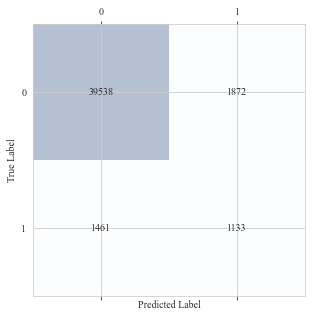

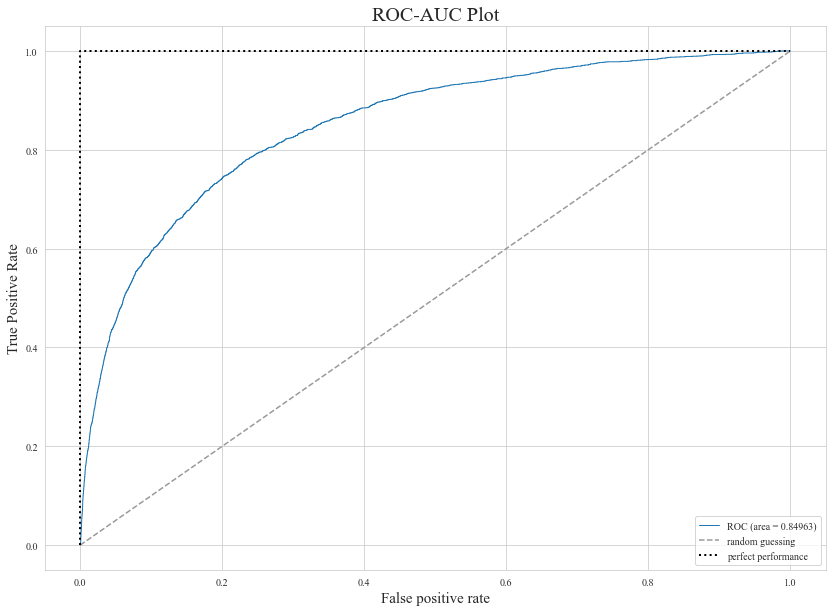

In [106]:
stdsc=StandardScaler()
X_training_std=stdsc.fit_transform(X_training)
X_validation_std=stdsc.fit_transform(X_validation)
lr=LogisticRegression()
lr.fit(X_training_std,y_training)
print('Training accuracy:', lr.score(X_training_std, y_training))
print('Test accuracy:', lr.score(X_validation, y_validation))
print("Test F1:", f1_score(y_validation,lr.predict(X_validation_std)))
confusion(X_validation_std, lr)
AUC_ROC(X_validation_std,lr)

logistic分类器的性能显然不能让我们满意, 我们下面考虑SVM分类器



### SVM
众所周知, SVM当有了核函数以后是不适合大量数据的. 我们先简单试一下线性核

Training accuracy: 0.865805757331181
Test accuracy: 0.9410508135624034
Test F1: 0.4010798303123794


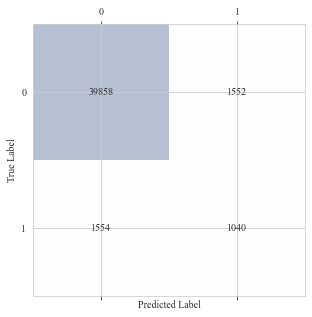

In [107]:
stdsc=StandardScaler()
X_training_std=stdsc.fit_transform(X_training)
X_validation_std=stdsc.fit_transform(X_validation)
clf= svm.LinearSVC().fit(X_training_std, y_training)
print('Training accuracy:', clf.score(X_training_std, y_training))
print('Test accuracy:', clf.score(X_validation, y_validation))
print("Test F1:", f1_score(y_validation,clf.predict(X_validation_std)))
confusion(X_validation_std, clf)

从 F1 value来看, 相比于最简单的logistics回归, SVM并没有明显的优势. 事实上, 这也是可以理解的. 因为SVM在更多情况下适合样本量较小但特征很多的数据, 对于我们这里的数据集并不适用, 并且训练也会很慢. 我们可以直接排除SVM模型

## 树家族
首先我们来定义一个avg_auc函数用于调参

In [108]:
def avg_auc(model):
    auc_list=[]
    for X_, y_, X__, y__ in zip(X_train_5,y_train_5,X_test_5,y_test_5):
        model.fit(X_,y_)
        auc=roc_auc_score(y__, model.predict_proba(X__)[:,-1])
        auc_list.append(auc)
    return np.array(auc_list)

### 随机森林
作为非常有效的手段, 让我们来使用树家族算法, 首先是随机森林. 树算法无需对数据做标准化处理

Training accuracy: 0.9994081248318536
Test accuracy: 0.9231206253976911
Test F1: 0.386582048957389


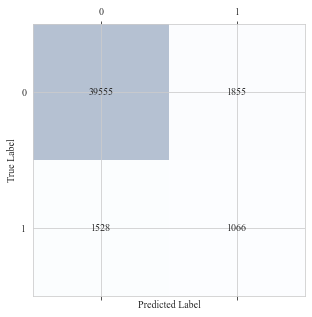

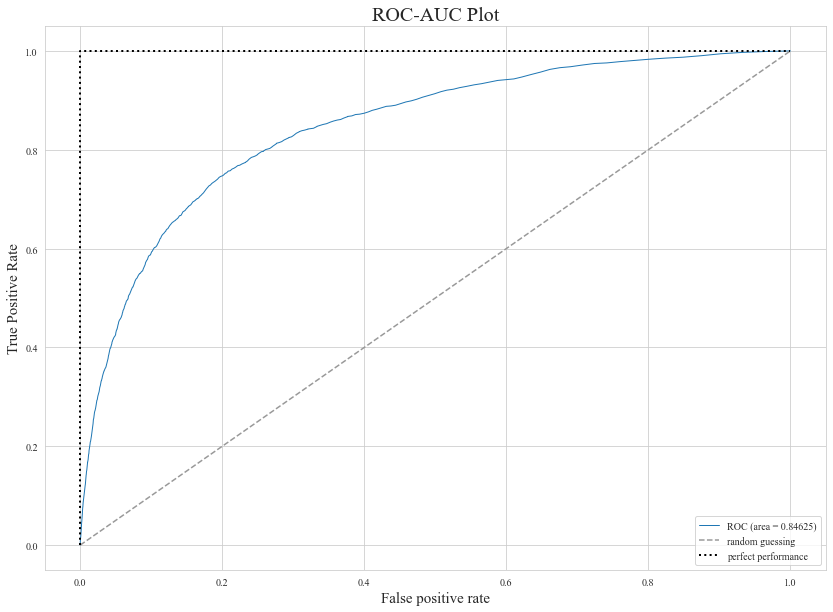

In [109]:
rfc=RandomForestClassifier(n_estimators=500, n_jobs=-1)
rfc.fit(X_training,y_training)
print('Training accuracy:', rfc.score(X_training, y_training))
print('Test accuracy:', rfc.score(X_validation, y_validation))
print("Test F1:", f1_score(y_validation,rfc.predict(X_validation)))
confusion(X_validation, rfc)
AUC_ROC(X_validation,rfc)

随机森林的初步效果看起来比较一般, 但这很明显是因为过拟合的缘故. 我们来对超参数进行一定的搜索

100%|██████████| 10/10 [00:51<00:00,  5.13s/it]


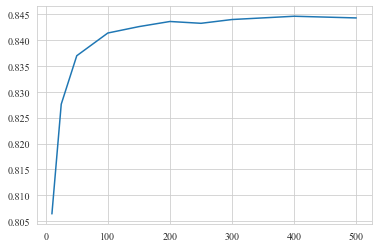

In [111]:
# 参数n_estimators
params_list=[10, 25, 50, 100, 150,200,250, 300,400, 500]
res=[]
res_avg=[]
for params in tqdm(params_list):
    model=RandomForestClassifier(n_estimators=params, n_jobs=-1)
    tmp=avg_auc(model)
    res.append(tmp)
    res_avg.append(tmp.mean())
plt.plot(params_list, res_avg)

可以看出, 在交叉验证中, 平均auc的结果随着n_estimators的增大而不断增大. 但在100以后增加的幅度不明显. 当n_estimators越大时, 过拟合的可能性越大, 且训练速度有所下降. 因此我们会选择一个折中的参数, n_estimators=400

100%|██████████| 10/10 [01:11<00:00,  7.18s/it]


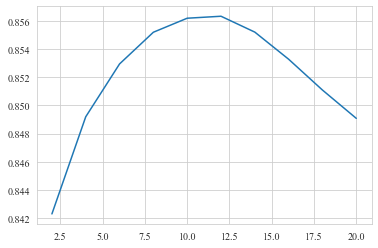

In [114]:
# 参数max_depth
params_list=np.arange(2,22,2)
res=[]
res_avg=[]
for params in tqdm(params_list):
    model=RandomForestClassifier(n_estimators=400,max_depth=params,n_jobs=-1)
    tmp=avg_auc(model)
    res.append(tmp)
    res_avg.append(tmp.mean())
plt.plot(params_list, res_avg)

上面的图表明了当深度过深的时候, 会发生过拟合, 样本外效果急速下降. 而当深度在8-14的时候, 有一个比较稳定的峰, 因此我们选择深度的参数为11

100%|██████████| 9/9 [01:04<00:00,  7.21s/it]


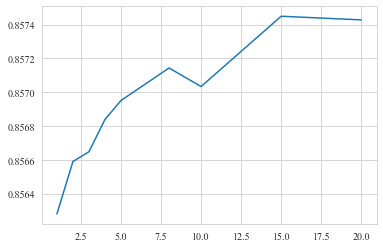

In [115]:
# 参数min_samples_leaf
params_list=[1, 2, 3, 4, 5, 8, 10, 15, 20]
res=[]
res_avg=[]
for params in tqdm(params_list):
    model=RandomForestClassifier(n_estimators=400,max_depth=11, min_samples_leaf=params,n_jobs=-1)
    tmp=avg_auc(model)
    res.append(tmp)
    res_avg.append(tmp.mean())
plt.plot(params_list, res_avg)

100%|██████████| 10/10 [01:11<00:00,  7.14s/it]


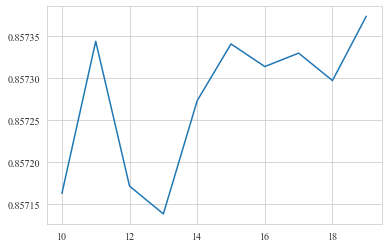

In [117]:
# 参数min_samples_leaf 继续搜索
params_list=np.arange(10,20,1)
res=[]
res_avg=[]
for params in tqdm(params_list):
    model=RandomForestClassifier(n_estimators=400,max_depth=11, min_samples_leaf=params,n_jobs=-1)
    tmp=avg_auc(model)
    res.append(tmp)
    res_avg.append(tmp.mean())
plt.plot(params_list, res_avg)

尽管这里的峰值并不足够稳定, 但我们仍然可以粗略的看出, 当参数在14-20之间的时候, 可以预期得到一个比较好的结果. 因此在这里我们选择参数为16

100%|██████████| 10/10 [00:57<00:00,  5.75s/it]


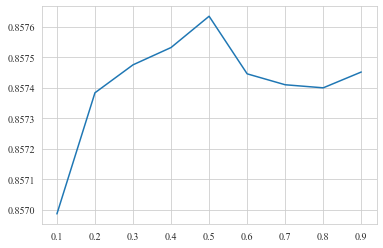

In [118]:
# max_samples
params_list=[None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
res=[]
res_avg=[]
for params in tqdm(params_list):
    model=RandomForestClassifier(n_estimators=400,max_depth=11, min_samples_leaf=16, max_samples=params,n_jobs=-1)
    tmp=avg_auc(model)
    res.append(tmp)
    res_avg.append(tmp.mean())
plt.plot(params_list, res_avg)

结合理论的先验认识和图像, 我们可以选择参数为0.5

Training accuracy: 0.8761904761904762
Test accuracy: 0.9308471957094809
Test F1: 0.40110214524699866


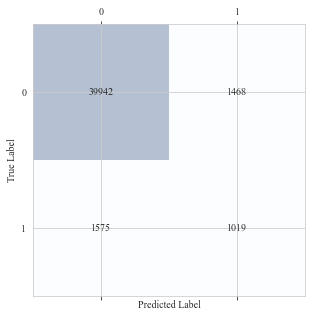

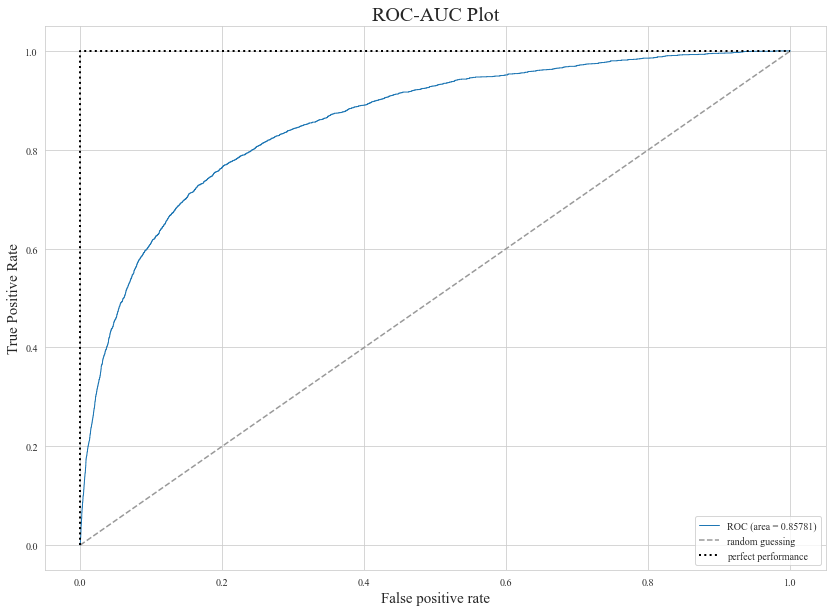

In [119]:
rfc=RandomForestClassifier(n_estimators=400,max_depth=11, min_samples_leaf=16, max_samples=0.5,n_jobs=-1)
rfc.fit(X_training,y_training)
print('Training accuracy:', rfc.score(X_training, y_training))
print('Test accuracy:', rfc.score(X_validation, y_validation))
print("Test F1:", f1_score(y_validation,rfc.predict(X_validation)))
confusion(X_validation, rfc)
AUC_ROC(X_validation,rfc)

### 极端随机森林.
极端随机森林因为随机选择的特性, 会比随机森林有着更好的泛化能力. 由于过拟合的威胁, 我们很自然地会尝试一下极端随机森林做法. 首先是不进行剪枝的极端随机森林

Training accuracy: 0.9994081248318536
Test accuracy: 0.9206208526497591
Test F1: 0.3772508468532716


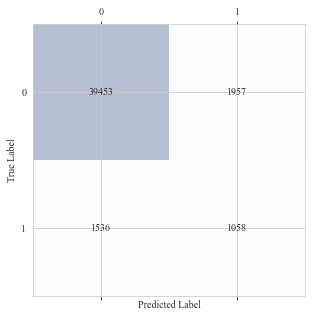

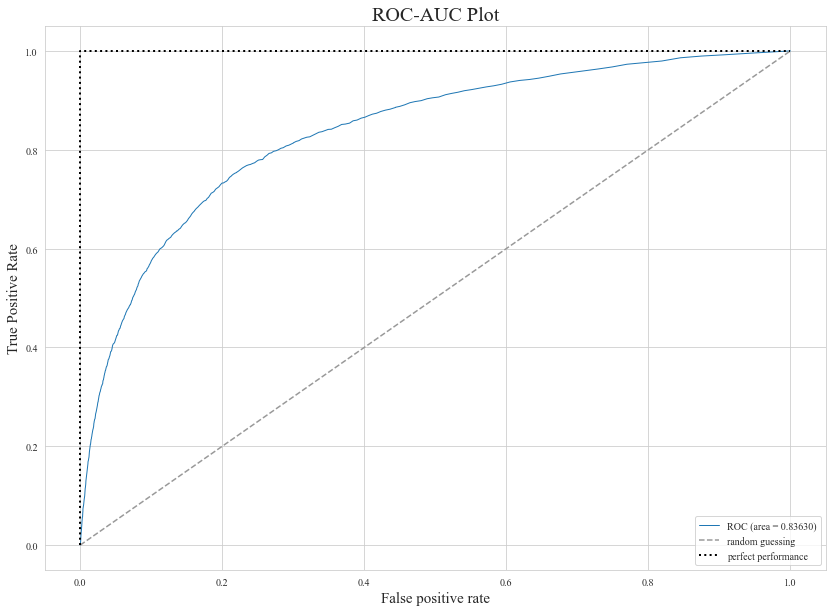

In [120]:
erfc=ExtraTreesClassifier(n_estimators=500, n_jobs=-1)
erfc.fit(X_training,y_training)
print('Training accuracy:', erfc.score(X_training, y_training))
print('Test accuracy:', erfc.score(X_validation, y_validation))
print("Test F1:", f1_score(y_validation,erfc.predict(X_validation)))
confusion(X_validation, erfc)
AUC_ROC(X_validation,erfc)

与随机森林算法相同, 不剪枝的极端随机森林有着比较大的过拟合的风险, 我们还是进行一定的剪枝操作. 下面是整个调参的过程

100%|██████████| 10/10 [00:38<00:00,  3.89s/it]


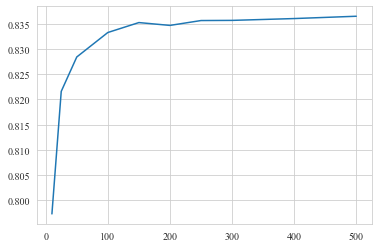

In [121]:
# 参数n_estimators
params_list = [10, 25, 50, 100, 150,200,250, 300,400, 500]
res = []
res_avg = []
for params in tqdm(params_list):
    model = ExtraTreesClassifier(n_estimators=params, n_jobs=-1)
    tmp = avg_auc(model)
    res.append(tmp)
    res_avg.append(tmp.mean())
plt.plot(params_list, res_avg)

可以看出, 平均auc的结果随着n_estimators的增大而不断增大. 但在100以后增加的幅度不明显. 当n_estimators越大时, 过拟合的倾向越明显, 且训练速度有所下降. 因此我们会选择一个折中的参数, n_estimators=200

100%|██████████| 10/10 [00:22<00:00,  2.26s/it]


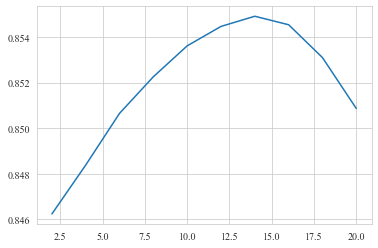

In [122]:
# 参数max_depth
params_list = np.arange(2, 22, 2)
res = []
res_avg = []
for params in tqdm(params_list):
    model = ExtraTreesClassifier(n_estimators=200, max_depth=params, n_jobs=-1)
    tmp = avg_auc(model)
    res.append(tmp)
    res_avg.append(tmp.mean())
plt.plot(params_list, res_avg)

上面的图表明了当深度过深的时候, 会发生过拟合, 样本外效果急速下降. 而当深度在12-16的时候, 有一个比较稳定的峰, 因此我们选择深度的参数为14

100%|██████████| 9/9 [00:22<00:00,  2.45s/it]


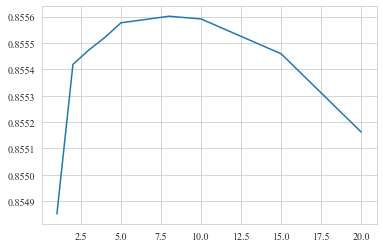

In [123]:
# 参数min_samples_leaf
params_list=[1, 2, 3, 4, 5, 8, 10, 15, 20]
res=[]
res_avg=[]
for params in tqdm(params_list):
    model=ExtraTreesClassifier(n_estimators=200, max_depth=14, min_samples_leaf=params,n_jobs=-1)
    tmp=avg_auc(model)
    res.append(tmp)
    res_avg.append(tmp.mean())
plt.plot(params_list, res_avg)

因此, 我们选择min_sample_leaf的参数值为8

Training accuracy: 0.8753833736884584
Test accuracy: 0.9308926461230798
Test F1: 0.39960513326752223


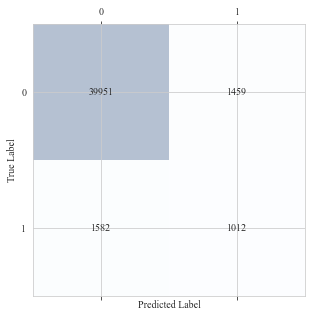

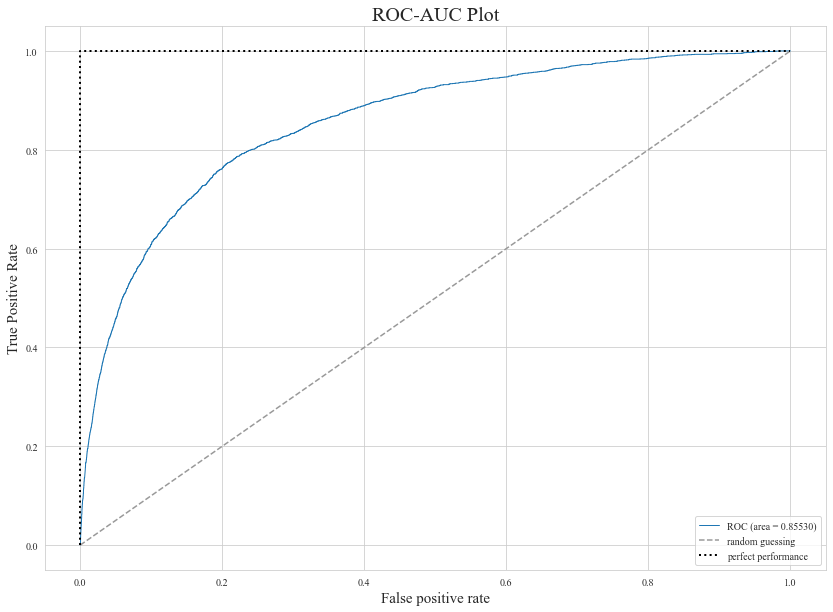

In [125]:
erfc=ExtraTreesClassifier(n_estimators=200, n_jobs=-1, max_depth=14, min_samples_leaf=8)
erfc.fit(X_training,y_training)
print('Training accuracy:', erfc.score(X_training, y_training))
print('Test accuracy:', erfc.score(X_validation, y_validation))
print("Test F1:", f1_score(y_validation,erfc.predict(X_validation)))
confusion(X_validation, erfc)
AUC_ROC(X_validation,erfc)

### XGBoost Tree
XGBoost是一个典型的gradient boosting decision tree. 其效果一般要远超上面两个模型

Training accuracy: 0.9326069410815173
Test accuracy: 0.9236433051540769
Test F1: 0.3798449612403101


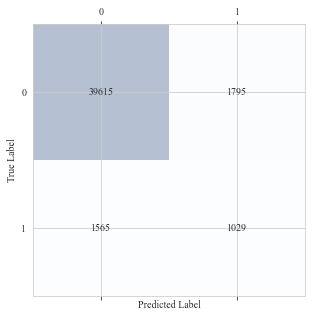

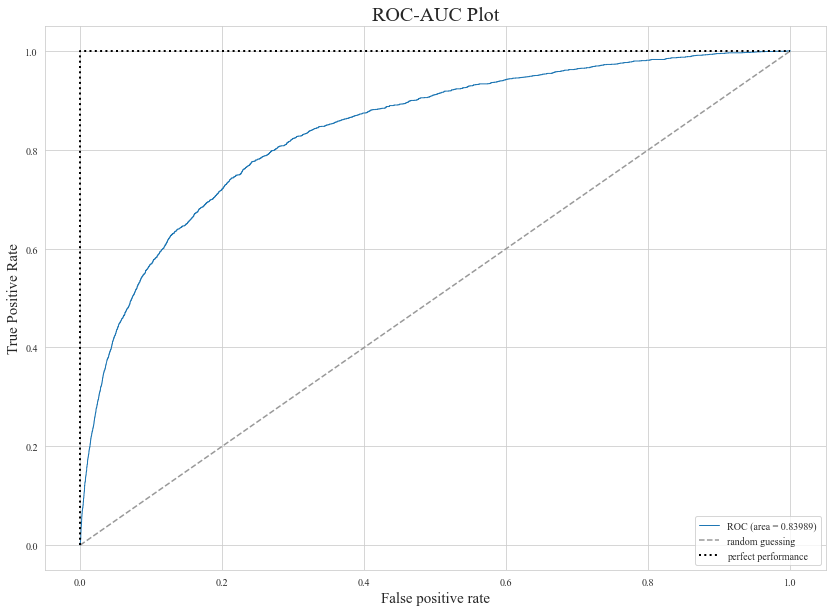

In [133]:
xgb=XGBClassifier(   eta=0.1,
                     colsample_bytree=0.5,
                     subsample=0.5,
                     max_depth=15,
                     min_child_weight=2,
                    )
xgb.fit(X_training,y_training)
print('Training accuracy:', xgb.score(X_training, y_training))
print('Test accuracy:', xgb.score(X_validation, y_validation))
print("Test F1:", f1_score(y_validation,xgb.predict(X_validation)))
confusion(X_validation, xgb)
AUC_ROC(X_validation,xgb)

下面是整个调参的过程

100%|██████████| 14/14 [01:13<00:00,  5.26s/it]


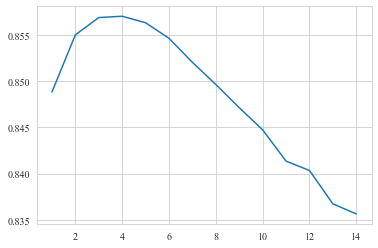

In [135]:
# max_depth 调参

params_list=np.arange(1,15,1)
res=[]
res_avg=[]
for params in tqdm(params_list):
    model=XGBClassifier(
                     eta=0.1,
                     colsample_bytree=0.5,
                     subsample=0.5,
                     max_depth=params,
                     min_child_weight=2,
                     scale_pos_weight=5
                    )
    tmp=avg_auc(model)
    res.append(tmp)
    res_avg.append(tmp.mean())
plt.plot(params_list, res_avg)

很明显, 在depth=4时有一个比较好的峰值, 因此我们可以取max_depth=4

100%|██████████| 9/9 [00:26<00:00,  2.94s/it]


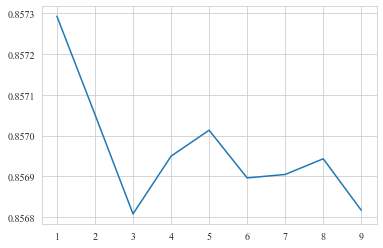

In [139]:
# scale_pos_weight 调参

params_list=np.arange(1,10,1)
res=[]
res_avg=[]
for params in tqdm(params_list):
    model=XGBClassifier(
                     eta=0.1,
                     colsample_bytree=0.5,
                     subsample=0.5,
                     max_depth=4,
                     min_child_weight=2,
                     scale_pos_weight=params
                    )
    tmp=avg_auc(model)
    res.append(tmp)
    res_avg.append(tmp.mean())
plt.plot(params_list, res_avg)

100%|██████████| 9/9 [00:26<00:00,  2.90s/it]


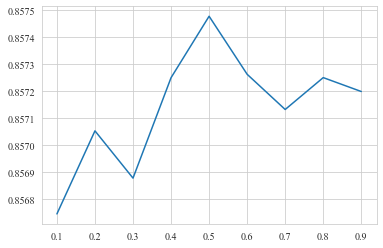

In [140]:
params_list=np.arange(1,10,1)/10
res=[]
res_avg=[]
for params in tqdm(params_list):
    model=XGBClassifier(
                     eta=0.1,
                     colsample_bytree=0.5,
                     subsample=0.5,
                     max_depth=4,
                     min_child_weight=2,
                     scale_pos_weight=params
                    )
    tmp=avg_auc(model)
    res.append(tmp)
    res_avg.append(tmp.mean())
plt.plot(params_list, res_avg)

很明显, 当scale_pos_weight=0.5时, 有一个不错的峰值. 因此, 取该参数为0.5

100%|██████████| 7/7 [00:20<00:00,  2.90s/it]


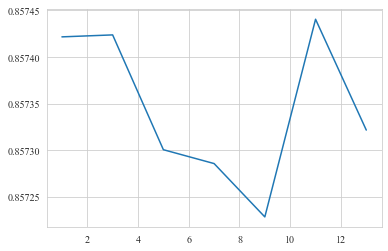

In [142]:
# min_child_weight 调参

params_list=np.arange(1,14,2)
res=[]
res_avg=[]
for params in tqdm(params_list):
    model=XGBClassifier(
                     eta=0.1,
                     colsample_bytree=0.5,
                     subsample=0.5,
                     max_depth=4,
                     min_child_weight=params,
                     scale_pos_weight=0.5
                    )
    tmp=avg_auc(model)
    res.append(tmp)
    res_avg.append(tmp.mean())
plt.plot(params_list, res_avg)

图像中找不到一个明显的峰值, 那么我们就本着简化的原则, 采取参数为1

100%|██████████| 9/9 [00:25<00:00,  2.81s/it]


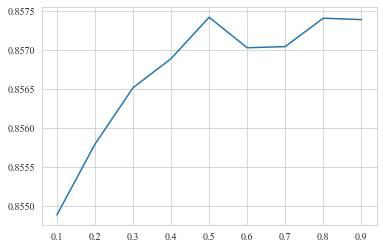

In [144]:
# subsample 调参
params_list=np.arange(0.1,1,0.1)
res=[]
res_avg=[]
for params in tqdm(params_list):
    model=XGBClassifier(
                     eta=0.1,
                     colsample_bytree=0.5,
                     subsample=params,
                     max_depth=4,
                     min_child_weight=1,
                     scale_pos_weight=0.5
                    )
    tmp=avg_auc(model)
    res.append(tmp)
    res_avg.append(tmp.mean())
plt.plot(params_list, res_avg)

大体上, 效果随着该参数的增加而增加, 而改参数的默认值为1, 本着约简原则, 我们取该参数为1

100%|██████████| 9/9 [00:24<00:00,  2.74s/it]


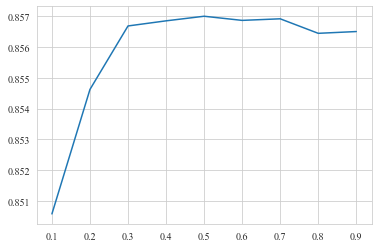

In [145]:
# colsample_bytree 调参
params_list=np.arange(0.1,1,0.1)
res=[]
res_avg=[]
for params in tqdm(params_list):
    model=XGBClassifier(
                     eta=0.1,
                     colsample_bytree=params,
                     subsample=1,
                     max_depth=4,
                     min_child_weight=1,
                     scale_pos_weight=0.5
                    )
    tmp=avg_auc(model)
    res.append(tmp)
    res_avg.append(tmp.mean())
plt.plot(params_list, res_avg)

大于0.3以后差距不大, 因此我们选择一个比较稳健的参数0.5

Training accuracy: 0.8665321495829971
Test accuracy: 0.9405054085992183
Test F1: 0.32974910394265233


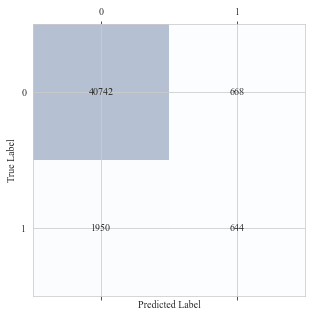

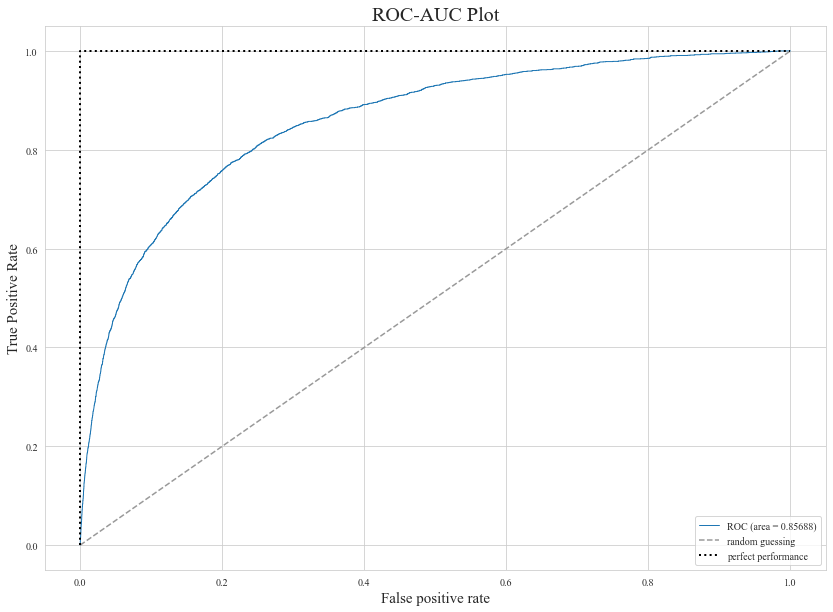

In [146]:
xgb=XGBClassifier(   eta=0.1,
                     colsample_bytree=0.5,
                     subsample=1,
                     max_depth=4,
                     min_child_weight=1,
                     scale_pos_weight=0.5
                    )
xgb.fit(X_training,y_training)
print('Training accuracy:', xgb.score(X_training, y_training))
print('Test accuracy:', xgb.score(X_validation, y_validation))
print("Test F1:", f1_score(y_validation,xgb.predict(X_validation)))
confusion(X_validation, xgb)
AUC_ROC(X_validation,xgb)

## 集成

In [147]:
clf1=LogisticRegression()
clf2=RandomForestClassifier(n_estimators=400,max_depth=11, min_samples_leaf=16, max_samples=0.5,n_jobs=-1)
clf3=ExtraTreesClassifier(n_estimators=200, n_jobs=-1, max_depth=14, min_samples_leaf=8)
clf4=XGBClassifier(   eta=0.1,
                     colsample_bytree=0.5,
                     subsample=1,
                     max_depth=4,
                     min_child_weight=1,
                     scale_pos_weight=0.5
                    )
vclf=VotingClassifier(estimators=[('rf', clf2), ('erf', clf3), ('xgb', clf4)],voting="soft")
vclf = vclf.fit(X_training,y_training)

Training accuracy: 0.8740112994350282
Test accuracy: 0.9360739932733387
Test F1: 0.3896723801258407


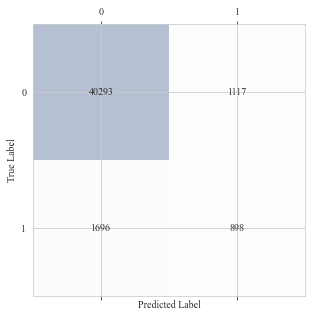

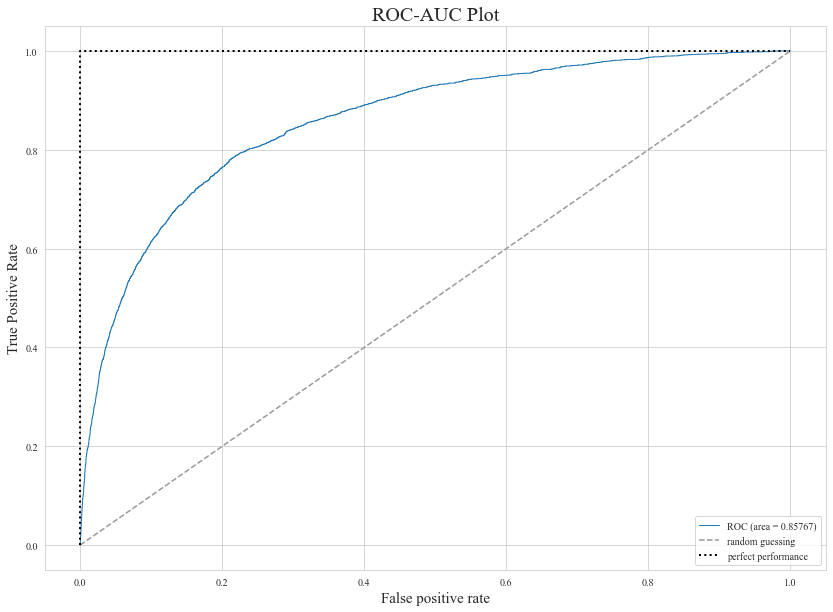

In [148]:
print('Training accuracy:', vclf.score(X_training, y_training))
print('Test accuracy:', vclf.score(X_validation, y_validation))
print("Test F1:", f1_score(y_validation,vclf.predict(X_validation)))
confusion(X_validation, vclf)
AUC_ROC(X_validation,vclf)

In [133]:
res=vclf.predict_proba(X_test)[:,-1]


In [137]:
data=pd.read_csv(r"Dataset/sampleEntry.csv")
data["Probability"]=res
data.to_csv(r"Dataset/sampleEntry.csv")